# Visium analysis - B progenitors

## Preparations

In [182]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
import os,sys
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.sparse
import anndata

In [184]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/spatial_mapping_EDA/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    

In [185]:
# ## Directory to save intermediate outputs
# writedir = "/nfs/team205/ed6/data/Fetal_immune/PAGA_FA_outs/"
# if not os.path.exists(writedir):
#     os.mkdir(writedir)    

In [186]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [187]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

Activate the anndata2ri conversion between SingleCellExperiment and AnnData

In [188]:
anndata2ri.activate()

In [189]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [190]:
%%R
library(tidyverse)

### Plotting utils

In [10]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [122]:
# pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

def get_pixel_size_visium(adata, library_id, spot_diameter_real = 55, img='lowres'):
    '''
    Utility function to get size of pixels from visium image in AnnData.
    Useful to plot scalebars with matplotlib_scalebar.ScaleBar
    
    Params:
    -------
    - adata: AnnData object storing image info in adata.uns[spatial]
    - library_id: string storing ID for image, must be a key in adata.uns[spatial]
    - spot_diameter_real: numeric storing real diameter of spot, in whatever unit you need 
        (default is 55, for 55 microns of Visium 10X spots)
    - img: which image to use (default: lowres)
    '''

    ## get scale factor converting original pixel positions (adata.obsm['spatial']) to 
    # pixel positions in image
    scalef = adata.uns['spatial'][library_id]['scalefactors']['tissue_{i}_scalef'.format(i=img)]
    ## get spot diameter in image pixels
    spot_diameter_img = adata.uns['spatial'][library_id]['scalefactors']['spot_diameter_fullres'] * scalef
    ## Calculate pixel size
    pixel_size_real = spot_diameter_real/spot_diameter_img
    return(pixel_size_real)


In [11]:
def _spatial_plot_lib(adata_vis, lib, color_by=None, **kwargs):
    with matplotlib.rc_context({"axes.facecolor": "black"}):
        s_ind = adata_vis.obs['sample'] == lib
        s_keys = list(adata_vis.uns['spatial'].keys())
        s_spatial = np.array(s_keys)[[lib in i for i in s_keys]][0]
        adata_small = adata_vis[s_ind, :].copy()
        sc.pl.spatial(adata_small, library_id=s_spatial,
                                **kwargs)
        
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value, return_list=False):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)
    if return_list:
        return(anno_order)
    

In [152]:
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :].copy()
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

def plot_spatial_per_cell_type(adata, 
                                   cell_type='total_counts',
                                   samples=['WSSS_F_IMMsp9838712', 'WSSS_F_IMMsp9838717', 
                                             'WSSS_F_IMMsp9838710', 
                                             'WSSS_F_IMMsp9838715', 
                                            'WSSS_F_IMMsp9838711', 'WSSS_F_IMMsp9838716'],
                               cmap='magma',
                                  ncol=3, prefix='', figsize=(18, 8), **kwargs):
        n_samples = len(samples)
        nrow = int(np.ceil(n_samples / ncol))
        fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
        if nrow == 1:
            axs = axs.reshape((1, ncol))
        if cell_type:
            col_name = f'{prefix}{cell_type}'
            vmax = np.quantile(adata[adata.obs["sample"].isin(samples)].obs[col_name].values, 0.992)
            adata.obs[cell_type] = adata.obs[col_name].copy()

        from itertools import chain
        ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))

        for i, s in enumerate(samples):
            sp_data_s = select_slide(adata, s, s_col='sample')
            lib_id = [x for x in sp_data_s.uns['spatial'].keys()][0]
            pix_size = get_pixel_size_visium(sp_data_s, lib_id, img='hires')
            if cell_type:
                sc.pl.spatial(sp_data_s, cmap=cmap,
                              color=cell_type, 
                              size=1, img_key='hires', alpha_img=1,
                              vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False, **kwargs
                                                )
                axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
                scalebar = ScaleBar(pix_size, "um", length_fraction=0.25, frameon=False, location='lower right')
                axs[ind[i][0],ind[i][1]].add_artist(scalebar)
            else: 
                sc.pl.spatial(sp_data_s,
                              color=cell_type, 
                              size=1, img_key='hires', alpha_img=1,
                              ax=axs[ind[i][0],ind[i][1]], show=False, **kwargs)
                axs[ind[i][0],ind[i][1]].title.set_text(s)
                scalebar = ScaleBar(pix_size, "um", length_fraction=0.25, frameon=False, location='lower right')
                axs[ind[i][0],ind[i][1]].add_artist(scalebar)
        fig.tight_layout(pad=0.5)

        return fig

In [13]:
def plot_w_ggplot(r_fct_str, args, figdir, pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(paste0(figdir, pl_name, ".png"), width=pl_width, height=pl_height)  +
        ggsave(paste0(figdir, pl_name, ".pdf"), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

In [14]:
select_slides = {
    'SP':['WSSS_F_IMMsp9838710', 'WSSS_F_IMMsp9838715'],
    "LI":['WSSS_F_IMMsp9838712', 'WSSS_F_IMMsp9838717'],
    "TH":['WSSS_F_IMMsp9838716', 'WSSS_F_IMMsp9838711'],
    }

def _plot_slides_spatial(adata_vis_full, 
                         col_name, 
                         samples = sum(select_slides.values(), []), 
                         ncol=4, vmin=0):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(18, 8))
    if nrow == 1:
        axs = axs.reshape((1, ncol))

    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))

    for i, s in enumerate(samples):
        vmax = np.quantile(adata_vis_full[adata_vis_full.obs["sample"].isin([s])].obs[col_name].values, 0.992)
        sns.set_context("notebook", font_scale=1.1)
        plt.rcParams["figure.figsize"] = [10,10]
        plt.rcParams['axes.titlesize'] = 32
        _spatial_plot_lib(adata_vis_full, color=[col_name], lib=s, ncols=1, size=1.3, vmin=vmin, vmax=vmax,
                          cmap="magma", frameon=False, title="",
                          ax=axs[ind[i][0],ind[i][1]], show=False
                         )
        plt.locator_params(axis='y', nbins=3)
        plt.rcParams['axes.titlesize'] = 20

    fig.tight_layout()
    return(fig)

In [15]:
%%R
library(patchwork)

plot_factor_id <- function(nmf_fractions, f, min_frac= 0.1, n_top=NULL, basesize=16,
                           highlight_cts = NULL
                          ){
    highlight_color = 'red'
    nmf_frac_df <- nmf_fractions %>%
        rownames_to_column('celltype') %>%
         pivot_longer(cols=-celltype, names_to="factor") %>%
        mutate(factor=str_remove(factor, 'mean_cell_type_factors')) 
    nmf_frac_df <- nmf_frac_df %>%
     filter(factor==paste0('fact_',f)) %>%
        filter(value > min_frac) %>%
        arrange(value) %>%
        mutate(celltype=factor(celltype, levels=celltype))
    
    if (!is.null(n_top)){
        nmf_frac_df <- nmf_frac_df %>%
        top_n(n_top, value)
    }
    
    if (!is.null(highlight_cts)){
       nmf_frac_df <- nmf_frac_df %>%
        mutate(ct_highlight=celltype %in% highlight_cts)
        label_colors <- ifelse(nmf_frac_df$celltype %in% highlight_cts, highlight_color,'black')
        label_facefont <- ifelse(nmf_frac_df$celltype %in% highlight_cts, 'bold','plain')
    }
    
    
    pl <- nmf_frac_df %>%
        ggplot(aes(value, celltype)) +
        geom_point(size=5) +
        geom_col(color='black', width=0.01) +
        theme_bw(base_size=basesize) +
        xlab("celltype fraction") +
        ggtitle(paste0("Factor", f))
    
    if (!is.null(highlight_cts)){
       pl <- pl +
        geom_point(data=. %>% filter(ct_highlight), size=6, color=highlight_color) +
        geom_col(data=. %>% filter(ct_highlight), color=highlight_color, width=0.02) +
        theme(axis.text.y = element_text(colour = label_colors, face=label_facefont))
    }
    
    return(pl)
    }

In [16]:
org_colors = pd.read_csv('../../metadata/organ_colors.csv')
org_colors

organ    color
0    YS  #0173b2
1    LI  #de8f05
2    BM  #029e73
3    TH  #d55e00
4    SP  #cc78bc
5   MLN  #ca9161
6    SK  #fbafe4
7    GU  #949494
8    KI  #ece133

In [2]:
def plot_nmf_fractions_ct(pl_df, org_fs, outfile, hm_height=10, hm_width=12):
    r_fct_str = '''
    library(tidyverse)
    plot_nmf_fractions <- function(pl_df, org_fs, outfile, save=TRUE, pl_height=10, pl_width=12){
        p1 <- pl_df %>%
            rownames_to_column("cell_type") %>%
            pivot_longer(cols=- cell_type, names_to="factor", values_to="ct_fraction") %>%
            mutate(factor=str_remove(factor, "mean_cell_type_factors")) %>%
            group_by(cell_type) %>%
            mutate(top_fact = which.max(ct_fraction)) %>%
            ungroup() %>%
            arrange(top_fact) %>%
            mutate(cell_type=factor(cell_type, levels=unique(cell_type))) %>%
            filter(factor %in% org_fs) %>%
            mutate(factor = factor(str_replace(factor, "fact_", "Factor "), levels=str_replace(org_fs, "fact_", "Factor "))) %>%
            ggplot(aes(factor, cell_type, color=ct_fraction, size=ct_fraction)) +
            geom_point() +
            scale_color_viridis_c(option='magma', direction=-1, name="cell type\nfraction", guide = "legend") +
            scale_size(name="cell type\nfraction") +
            ylab("cell type") +
            theme_bw(base_size=14) +
            theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)
                 )
        if (isTRUE(save)){
            print(paste0('saving to ', outfile))
            ggsave(paste0(outfile, '.pdf'), p1, height=pl_height, width=pl_width)
            ggsave(paste0(outfile, '.png'), p1, height=pl_height, width=pl_width)
          } else {
           print("not saving")
          p1   
        }
    }
    '''

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    # PASS OBJECTS INTO FUNCTION
    r_pkg.plot_nmf_fractions(pl_df, org_fs, outfile, pl_height = hm_height, pl_width = hm_width)

def plot_nmf_spatial(adata_vis, org_fs, lib, outfile, ncols=2):
    ## Save spatial plots 
    sns.set_context("talk")
    plt.rcParams["figure.figsize"] = [10,10]
    plt.rcParams['axes.titlesize'] = 32
    plt_titles = [None] + ["Factor " + x.split("_")[1] for x in org_fs.values]
    _spatial_plot_lib(adata_vis, color=[None] + list(org_fs.values), lib=lib, ncols=ncols, size=1.3, 
                      save=outfile, frameon=False,
                      title=plt_titles, show=False
                     )
    plt.rcParams['axes.titlesize'] = 20


def get_nmf_frac_4_plotting(nmf_fractions, org, org_fs, min_prop=0.25):
    ## Filter cell types by minimum proportion assigned to fraction
    filt_nmf_fractions = nmf_fractions[nmf_fractions[['mean_cell_type_factors' + x for x in org_fs]].max(1) > min_prop]
    pl_df = filt_nmf_fractions[['mean_cell_type_factors' + x for x in org_fs]]

    ## Exclude low Q annotations
    pl_df = pl_df[~pl_df.index.isin(anno_groups_dict["OTHER"])]
    return(pl_df)

### Load scRNA-seq cell numbers
used for further filtering

In [158]:
## Filter maternal contaminants
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
## Abundance in sc data
sc_ct_donor_counts = anno_obs[anno_obs.organ.isin(["TH", "LI", "SP", "GU"])].groupby(['organ','anno_lvl_2_final_clean', 'donor']).count().unstack(fill_value=0).stack()
sc_ct_donor_counts = sc_ct_donor_counts.reset_index()[['organ','anno_lvl_2_final_clean','donor', 'n_genes']]
sc_ct_donor_counts.columns = ['organ','anno_lvl_2_final_clean','donor','n_cells']

In [160]:
%%R -i sc_ct_donor_counts -o ct_donor_filter
ct_donor_filter <- sc_ct_donor_counts %>%
    group_by(organ, anno_lvl_2_final_clean) %>%
    summarise(donor_pass=sum(n_cells > 10) >= 3) %>%
    ungroup() %>%
    filter(donor_pass) %>%
    select(organ, anno_lvl_2_final_clean)

`summarise()` has grouped output by 'organ'. You can override using the `.groups` argument.


In [161]:
def ct_donor_pass_filter(ct, org):
    return(ct in ct_donor_filter[ct_donor_filter.organ == org]['anno_lvl_2_final_clean'].values)

In [162]:
ct_donor_pass_filter('CD8AA', "SP")

True

## Read cell2location mapping results

In [17]:
def read_c2l(c2l_outdir, skip_organ=False):
    adata_vis = sc.read_h5ad(c2l_outdir + "sp.h5ad")
    if not skip_organ:
        adata_vis.obs["Organ"] = adata_vis.obs["Organ"].str[0:2]

    ## Add total cell abundance
    adata_vis.obs['total_cell_abundance'] = adata_vis.uns['mod']['post_sample_means']['w_sf'].sum(1).flatten()

    # add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
    # to adata.obs with nice names for plotting
    # adata_vis.obs[adata_vis.uns['mod']['factor_names']] = (adata_vis.obsm['q05_cell_abundance_w_sf'].T/adata_vis.obs["total_cell_abundance"]).T
    adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf'].copy()

    ## Make metadata table for libraries
    vis_sample_metadata = adata_vis.obs[["sample", 'Organ', "Age_PCW", "Fetal_id"]].drop_duplicates()
    vis_sample_metadata.index = vis_sample_metadata['sample'].copy()
    vis_sample_metadata = vis_sample_metadata.drop("sample", 1)

    ## Ref celltypes info
    celltypes_df = pd.DataFrame(adata_vis.uns['mod']['factor_names'], columns=['annotation'])
    celltypes_df['anno_group'] = [anno_groups_dict_rev[c] if c in anno_groups_dict_rev.keys() else "STROMAL" for c in celltypes_df.annotation]
    celltypes_df['stromal_organ'] = np.nan
    celltypes_df.loc[celltypes_df['anno_group'] == "STROMAL", "stromal_organ"] = [x[-1] for x in celltypes_df[celltypes_df['anno_group'] == "STROMAL"].annotation.str.split("_")]

    celltypes_df.index = celltypes_df['annotation'].copy()
    return(adata_vis, celltypes_df, vis_sample_metadata)

In [18]:
c2l_results_dir = '/nfs/team205/vk7/sanger_projects/collaborations/pan_fetal_immune_mapping/results/'

In [19]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
anno_groups_dict_rev = {"_".join(k.split("/")):v for k,v in anno_groups_dict_rev.items()}

In [20]:
ids = ['SP_revisedTissueFilter_v2annot', "LI_v2annot_revisedTissuefilter", 'TH_fetal_TECs_revisedTissuefilter_v2annot']
organs = ['SP', "LI", "TH"]
c2l_outdirs = [c2l_results_dir + 'spatial_mapping_{i}_epochs50k_alphatest20/'.format(i=ids[i]) for i in range(len(ids))]

res_ls = [read_c2l(outdir) for outdir in c2l_outdirs]    

c2l_results = {organs[i]:res_ls[i][0] for i in range(len(res_ls))}

In [21]:
vis_sample_metadata = pd.concat([res_ls[i][2] for i in range(len(res_ls))], ignore_index=True)
vis_sample_metadata.index = np.concatenate([res_ls[i][2].index.astype("str") for i in range(len(res_ls))])

In [22]:
vis_sample_metadata

Organ Age_PCW Fetal_id
WSSS_F_IMMsp9838709     SP      11     F117
WSSS_F_IMMsp9838710     SP      18     F121
WSSS_F_IMMsp9838714     SP      11     F117
WSSS_F_IMMsp9838715     SP      18     F121
WSSS_F_IMMsp10864181    SP      18     F136
WSSS_F_IMMsp10864182    SP      18     F136
WSSS_F_IMMsp9838712     LI      18     F121
WSSS_F_IMMsp9838717     LI      18     F121
WSSS_F_IMMsp10864180    LI      15     F122
WSSS_F_IMMsp10864184    LI      18     F136
WSSS_F_IMMsp9838711     TH      18     F121
WSSS_F_IMMsp9838716     TH      18     F121
WSSS_F_IMMsp10864183    TH      18     F136

In [23]:
## Exclude 11PCW spleen for now
c2l_results['SP'] = c2l_results['SP'][c2l_results['SP'].obs["Age_PCW"] != '11'].copy()
vis_sample_metadata = vis_sample_metadata[vis_sample_metadata.Age_PCW !='11']

In [24]:
## Exclude low quality liver slide
c2l_results['LI'] = c2l_results['LI'][~c2l_results['LI'].obs["sample"].str.endswith("180")].copy()
vis_sample_metadata = vis_sample_metadata[~vis_sample_metadata.index.str.endswith('180')]
 

## Read NMF results

In [1]:
def read_nmf(c2l_outdir, n_fact, out_type='ct_fractions', dirname=None):
    nmf_outdir = c2l_outdir + 'CoLocatedComb/' + os.listdir(c2l_outdir + 'CoLocatedComb/')[0]
    if dirname is not None:
        nmf_outdir = c2l_outdir + 'CoLocatedComb/' + dirname
    if out_type == 'ct_fractions':
        ct_frac_outdir = nmf_outdir + "/cell_type_fractions_mean/"
        fact_mat = [x for x in os.listdir(ct_frac_outdir) if "n_fact" + str(n_fact) in x][0]
        out = pd.read_csv(ct_frac_outdir + fact_mat, index_col=0)
    elif out_type == "location":
        loc_outdir = nmf_outdir + "/location_factors_mean/"
        fact_mat = [x for x in os.listdir(loc_outdir) if "n_fact" + str(n_fact) in x][0]
        out = pd.read_csv(loc_outdir + fact_mat, index_col=0)
    return(out)

def get_undetected_cts(adata_vis, vis_sample_metadata, detection_thresh = 0.15):
    max_val_sample = adata_vis.obs[adata_vis.uns['mod']['factor_names'].tolist() + ['sample']].groupby('sample').quantile(q=0.992).T
    return(max_val_sample.index[(max_val_sample < detection_thresh).sum(1) > 1])
    

def get_colocation_from_nmf(adata_vis, vis_sample_metadata, c2l_outdir, n_factors, min_frac = 0.2, detection_thresh=0.15):
    ## Read celltype fractions 
    nmf_fractions = read_nmf(c2l_outdir, n_fact=n_factors)
    ## Exclude undetected cts
    exclude_cts = get_undetected_cts(adata_vis, vis_sample_metadata, detection_thresh=detection_thresh)
    nmf_fractions = nmf_fractions[~nmf_fractions.index.isin(exclude_cts)]
    ## Filter by minimum fraction associated to factor 
    nmf_fractions = nmf_fractions.mask(nmf_fractions < min_frac, other=0)
    coloc_df = nmf_fractions.mask(nmf_fractions > 0, other=1)
    coloc_df.columns = ['fact_'+str(i) for i in range(n_factors)]
    return(coloc_df)

def pick_n_factors(c2l_outdir, n_fact_range=range(10,20)):
    max_cors = []
    for n in n_fact_range:
        nmf_fractions = read_nmf(c2l_outdir, n_fact=n)
        fact_cors = np.corrcoef(nmf_fractions.T)
        np.fill_diagonal(fact_cors, 0)
        max_cor = fact_cors.max()
        max_cors.append(max_cor)
    return(n_fact_range[np.argmin(max_cors)])

In [164]:
dirnames = {
    "SP":'CoLocatedGroupsSklearnNMF_11355locations_78factors',
    "LI":'CoLocatedGroupsSklearnNMF_10351locations_81factors',
    'TH':'CoLocatedGroupsSklearnNMF_4675locations_72factors'
}

min_frac = 0.15
c2l_outdirs_dict = dict(zip(organs, c2l_outdirs))
n_factors_dict = {k:10 for k in c2l_outdirs_dict.keys()}

nmf_fractions_dict = {k:read_nmf(c2l_outdirs_dict[k], n_factors_dict[k]) for k in c2l_outdirs_dict.keys()}

## Read fraction values to locations
for o in organs:
    dirname = dirnames[o]
    nmf_mat = read_nmf(c2l_outdirs_dict[o], n_fact=n_factors_dict[o], out_type='location', dirname=dirname)
    c2l_results[o].obsm["NMF"] = nmf_mat.loc[c2l_results[o].obs_names]
    c2l_results[o].obsm["NMF"].columns = [x[1] for x in c2l_results[o].obsm["NMF"].columns.str.split("mean_nUMI_factors")]
    c2l_results[o].obsm["NMF"] = c2l_results[o].obsm["NMF"].mask(c2l_results[o].obsm["NMF"] < min_frac, 0)
    ## Remove 0-based indexing
    # c2l_results[o].obsm["NMF"].columns =  [x[0] + "_" + str(int(x[1]) + 1) for x in c2l_results[o].obsm["NMF"].columns.str.split("_")]
    if any([x in c2l_results[o].obs.columns for x in c2l_results[o].obsm["NMF"].columns]):
        c2l_results[o].obs = c2l_results[o].obs.drop(c2l_results[o].obsm["NMF"].columns, 1)
    c2l_results[o].obs = pd.concat([c2l_results[o].obs, c2l_results[o].obsm["NMF"]], 1)

## Filter out celltypes not found across donors in sc data
for o in organs:
    nmf_fractions_dict[o] = nmf_fractions_dict[o].loc[[x for x in nmf_fractions_dict[o].index if ct_donor_pass_filter(x, o) or  "TEC" in x]]

In [173]:
## Add results for gut
outdir = c2l_results_dir + 'spatial_mapping_multiorgan_GU_tissueQCfilter_epochs50k_alphatest20/'
gu_results = read_c2l(outdir, skip_organ=True)

c2l_results['GU'] = gu_results[0]

o = "GU"
nmf_fractions_dict[o] = read_nmf(outdir, 10)

## Read fraction values to locations
nmf_mat = read_nmf(outdir, n_fact=10, out_type='location')
c2l_results[o].obsm["NMF"] = nmf_mat.loc[c2l_results[o].obs_names]
c2l_results[o].obsm["NMF"].columns = [x[1] for x in c2l_results[o].obsm["NMF"].columns.str.split("mean_nUMI_factors")]
c2l_results[o].obsm["NMF"] = c2l_results[o].obsm["NMF"].mask(c2l_results[o].obsm["NMF"] < min_frac, 0)
## Remove 0-based indexing
# c2l_results[o].obsm["NMF"].columns =  [x[0] + "_" + str(int(x[1]) + 1) for x in c2l_results[o].obsm["NMF"].columns.str.split("_")]
if any([x in c2l_results[o].obs.columns for x in c2l_results[o].obsm["NMF"].columns]):
    c2l_results[o].obs = c2l_results[o].obs.drop(c2l_results[o].obsm["NMF"].columns, 1)
c2l_results[o].obs = pd.concat([c2l_results[o].obs, c2l_results[o].obsm["NMF"]], 1)

## Filter out celltypes not found across donors in sc data
nmf_fractions_dict[o] = nmf_fractions_dict[o].loc[[x for x in nmf_fractions_dict[o].index if ct_donor_pass_filter(x, o)]]

---

## Find microenvironment factors containing B progenitors

In [175]:
progenitor_groups = {
    'T_prog':["DN(early)_T","DN(Q)_T", "DN(P)_T"],
    'B_prog' :['PRE_PRO_B','PRO_B','LATE_PRO_B','LARGE_PRE_B','SMALL_PRE_B'],
    'MEM_prog' : ['MEMP', 'CYCLING_MEMP', 'MEP'],
    'MYE_prog' : ['CMP','DC_PROGENITOR','GMP','MOP','MYELOCYTE','PROMONOCYTE','PROMYELOCYTE']
    }

progenitor_groups_rev = {x:k for k,v in progenitor_groups.items() for x in v }

In [176]:
all_organs = ['LI', "TH", "SP", "GU"]

In [177]:
min_frac = 0.5
bprog_factors = {}
for org in all_organs:
    keep_b_prog = [x for x in progenitor_groups['B_prog'] if x in nmf_fractions_dict[org].index]
    bprog_factors[org] = ['fact_' + str(x) for x in np.where(nmf_fractions_dict[org].loc[keep_b_prog].sum(0)[0:10] > min_frac)[0]]

bprog_factors

{'LI': ['fact_2', 'fact_3', 'fact_5'],
 'TH': ['fact_3', 'fact_9'],
 'SP': ['fact_1', 'fact_3'],
 'GU': ['fact_4']}

In [178]:
orgs_pl_df = {}
for org in all_organs:
    org_fs = bprog_factors[org]
    pl_df = get_nmf_frac_4_plotting(nmf_fractions_dict[org], 
                                    org, org_fs, min_prop=0.25)
    pl_df['organ'] = org
    pl_df['celltype'] = pl_df.index
    pl_df = pl_df.melt(id_vars=['organ', 'celltype'])
    orgs_pl_df[org] = pl_df

orgs_pl_df = pd.concat([x for x in orgs_pl_df.values()], 0)

In [179]:
## Order celltypes by no. of organs in which they interact w B progenitors
shared_ct_rank = orgs_pl_df[['organ', 'celltype']].drop_duplicates().\
    groupby('celltype').size().\
    sort_values().\
    reset_index()
shared_ct_rank.columns = ['celltype', 'n_organs']

In [180]:
orgs_pl_df = pd.merge(orgs_pl_df, shared_ct_rank, how='left')

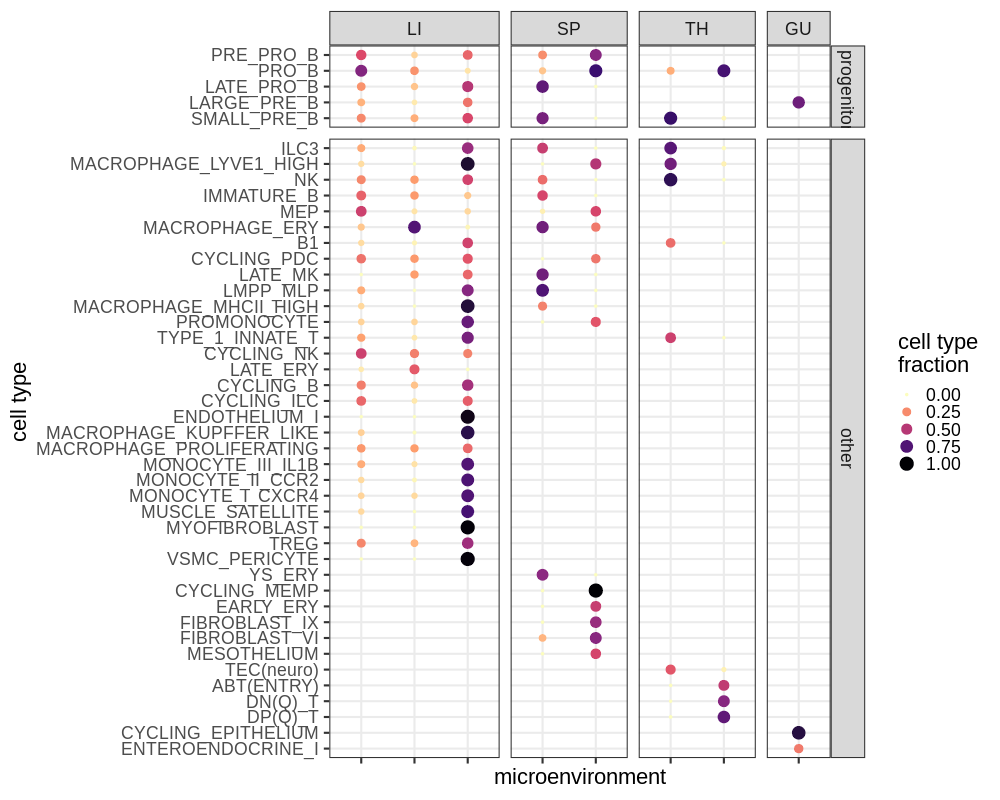

In [191]:
%%R -i orgs_pl_df -w 1000 -h 800 -o orgs_pl_df -i figdir
b_prog <- c('PRE_PRO_B','PRO_B','LATE_PRO_B','LARGE_PRE_B','SMALL_PRE_B')

keep_cts <- orgs_pl_df %>%
        mutate(factor=str_remove(variable, "mean_cell_type_factors")) %>%
        group_by(organ, factor) %>%    
        slice_max(order_by = value, n = 10) %>%
        pull(celltype) %>% unique()
        
orgs_pl_df %>%
    filter(celltype %in% keep_cts) %>%
    mutate(B_prog = ifelse(celltype %in% b_prog, 'B progenitors', 'other')) %>%
    mutate(factor=str_remove(variable, "mean_cell_type_factors")) %>%
    mutate(factor=paste0(factor,organ)) %>%
            group_by(celltype, organ, B_prog) %>%
            mutate(top_fact = which.max(value)) %>%
            ungroup() %>%
            mutate(organ=factor(organ, levels=c("LI", "SP", "TH", "GU"))) %>%
            arrange(desc(n_organs),organ, top_fact) %>%
            mutate(celltype=factor(celltype, levels=c(rev(c("PRE_PRO_B", "PRO_B", "LATE_PRO_B", "LARGE_PRE_B", "SMALL_PRE_B")),
                                                      rev(unique(celltype)[!unique(celltype) %in% c("PRE_PRO_B", "PRO_B", "LATE_PRO_B", "LARGE_PRE_B", "SMALL_PRE_B")])))) %>%
            ggplot(aes(factor, celltype, color=value, size=value)) +
            geom_point() +
            scale_color_viridis_c(option='magma', direction=-1, name="cell type\nfraction", guide = "legend") +
            scale_size(name="cell type\nfraction") +
            ylab("cell type") + xlab("microenvironment") +
            facet_grid(B_prog~organ, scales='free', space="free") +
            theme_bw(base_size=22) +
            theme(axis.text.x=element_blank(),
#                   strip.text.y=element_text(angle=0)
                 ) +
            ggsave(paste0(figdir, 'Bprog_factors_heatmap_v1.pdf'), width=12, height=12)

In [309]:
# orgs_pl_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/spatial_analysis_outs/NMF_celltype_fractions.Bprogenitors.csv')

# orgs_pl_df = {}
# for org in all_organs:
#     pl_df = get_nmf_frac_4_plotting(nmf_fractions_dict[org], 
#                                     org, ['fact_' + str(x) for x in range(10)], min_prop=0.25)
#     pl_df['organ'] = org
#     pl_df['celltype'] = pl_df.index
#     pl_df = pl_df.melt(id_vars=['organ', 'celltype'])
#     orgs_pl_df[org] = pl_df

# orgs_pl_df = pd.concat([x for x in orgs_pl_df.values()], 0)

# orgs_pl_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/spatial_analysis_outs/NMF_celltype_fractions.all_organs.csv')

### Check overlap with lymphoid aggregates in spleen

In [234]:
## Define factors for lymphoid aggregates
lym_aggregates_factor = 'fact_8'

samples = vis_sample_metadata.index[vis_sample_metadata.Organ=="SP"]
c2l_results["SP"].obs['lym_aggregate_region'] = 0
for s in samples:
    keep_obs = c2l_results["SP"].obs['sample'] == s
    quant = np.quantile(c2l_results["SP"].obs.loc[keep_obs, lym_aggregates_factor], 0.9)
    c2l_results["SP"].obs.loc[keep_obs, 'lym_aggregate_region'] = (c2l_results["SP"].obs.loc[keep_obs, lym_aggregates_factor] > quant).astype('int')

... storing 'Organ' as categorical
... storing 'Organ' as categorical
... storing 'Organ' as categorical
... storing 'Organ' as categorical


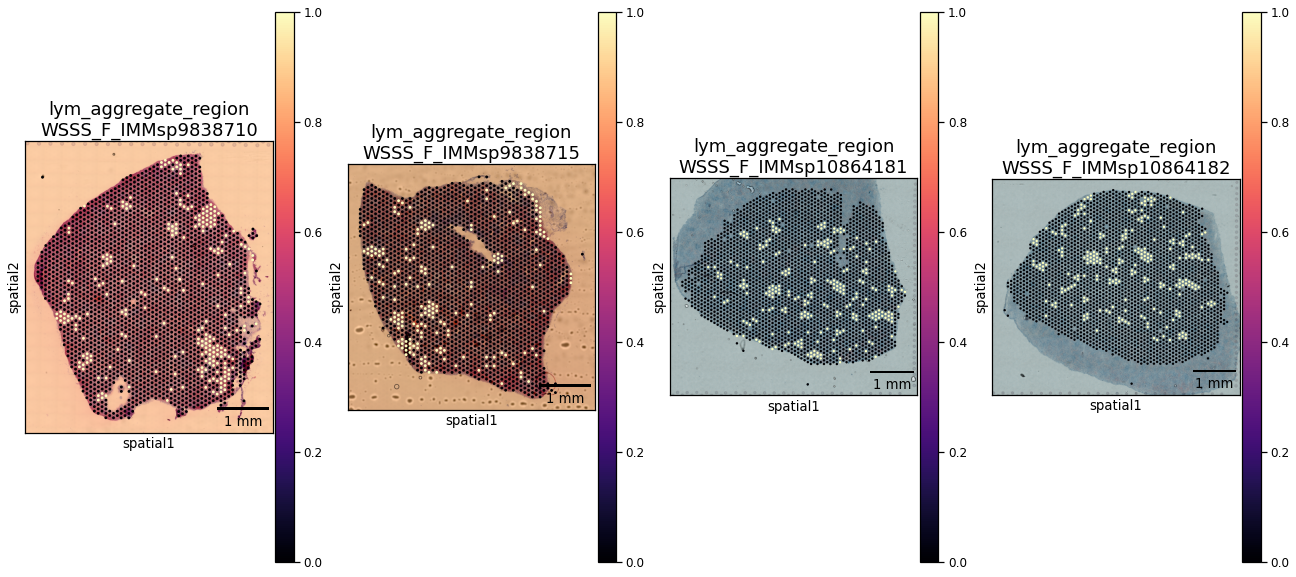

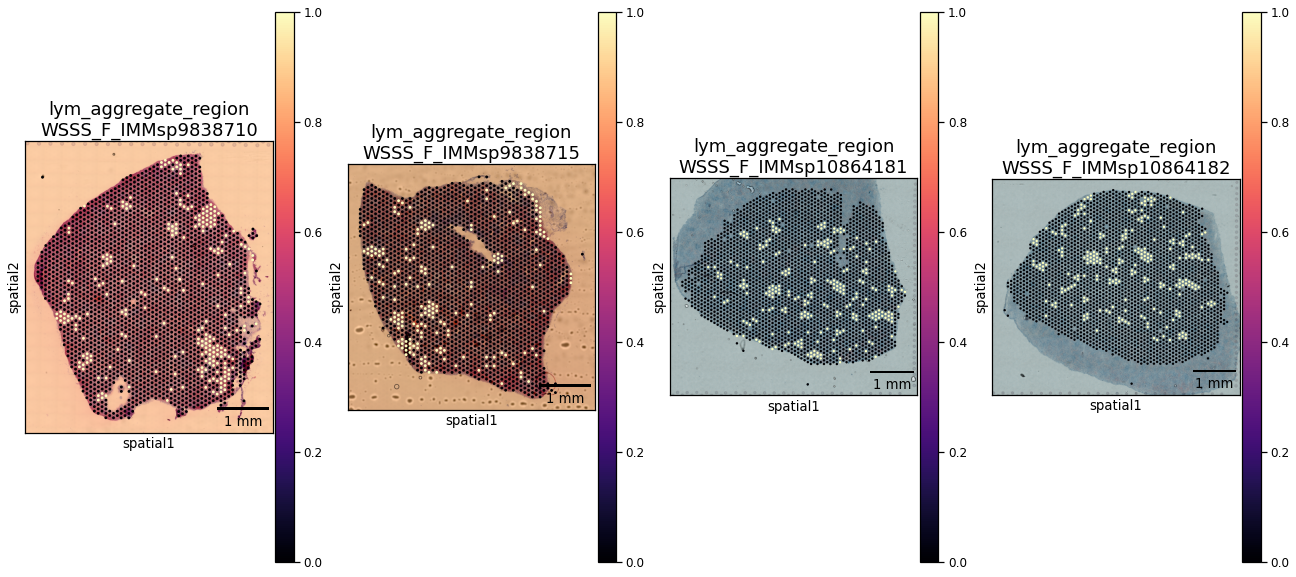

In [235]:
plot_spatial_per_cell_type(c2l_results["SP"], cell_type="lym_aggregate_region", 
                           samples=vis_sample_metadata.index[vis_sample_metadata.Organ=="SP"], ncol=len(samples))

In [236]:
## Define factors for lymphoid aggregates
samples = vis_sample_metadata.index[vis_sample_metadata.Organ=="SP"]
c2l_results["SP"].obs['B_prog_region'] = 0
for s in samples:
    keep_obs = c2l_results["SP"].obs['sample'] == s
    quant = np.quantile(c2l_results["SP"].obs.loc[keep_obs, 'B_progenitors'], 0.9)
    c2l_results["SP"].obs.loc[keep_obs, 'B_prog_region'] = (c2l_results["SP"].obs.loc[keep_obs, "B_progenitors"] > quant).astype('int')

... storing 'Organ' as categorical
... storing 'Organ' as categorical
... storing 'Organ' as categorical
... storing 'Organ' as categorical


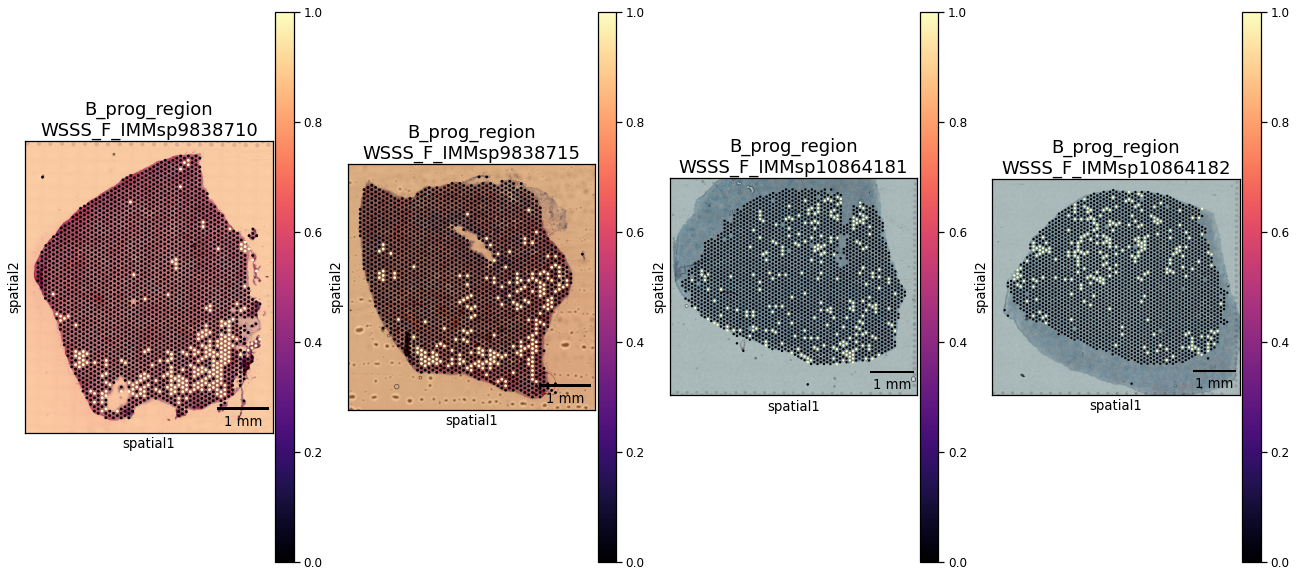

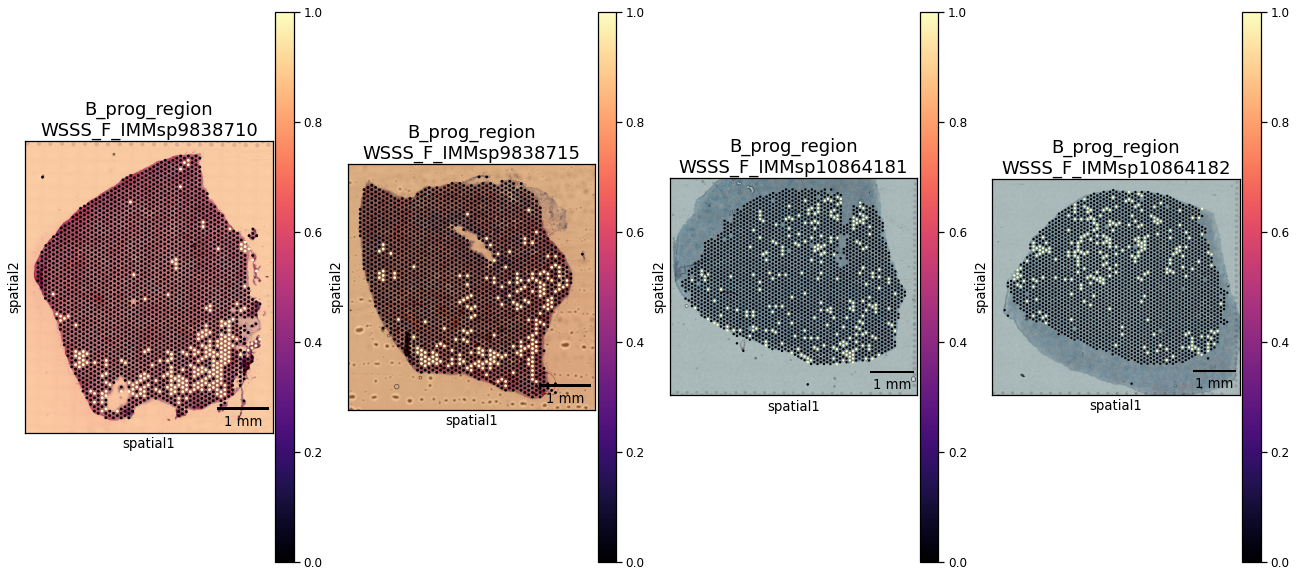

In [237]:
plot_spatial_per_cell_type(c2l_results["SP"], cell_type="B_prog_region", 
                           samples=vis_sample_metadata.index[vis_sample_metadata.Organ=="SP"], ncol=len(samples))

In [315]:
## Define spatial neighbourhood graph
sq.gr.spatial_neighbors(c2l_results["SP"], n_rings=1, coord_type="grid", n_neighs=6)

In [330]:
## Distance to ROI
def distance2ROI(adata_vis, ROI_col):
    from scipy.spatial import distance
    adata_vis.obsp['spatial_distances_all'] = distance.squareform(distance.pdist(adata_vis.obs[['array_row','array_col']]))

    in_roi = adata_vis.obs[ROI_col] == 1
    out_roi = adata_vis.obs[ROI_col] == 0

    ## Find distance to ROI
    adata_vis.obs['mean_dist2ROI'] = adata_vis.obsp['spatial_distances_all'][:,in_roi].mean(1).round()
    adata_vis.obs['min_dist2ROI'] = adata_vis.obsp['spatial_distances_all'][:,in_roi].min(1).round()
    return(adata_vis)


In [331]:
c2l_results["SP"] = distance2ROI(c2l_results["SP"], 'lym_aggregate_region')

... storing 'Organ' as categorical
... storing 'Organ' as categorical
... storing 'Organ' as categorical
... storing 'Organ' as categorical


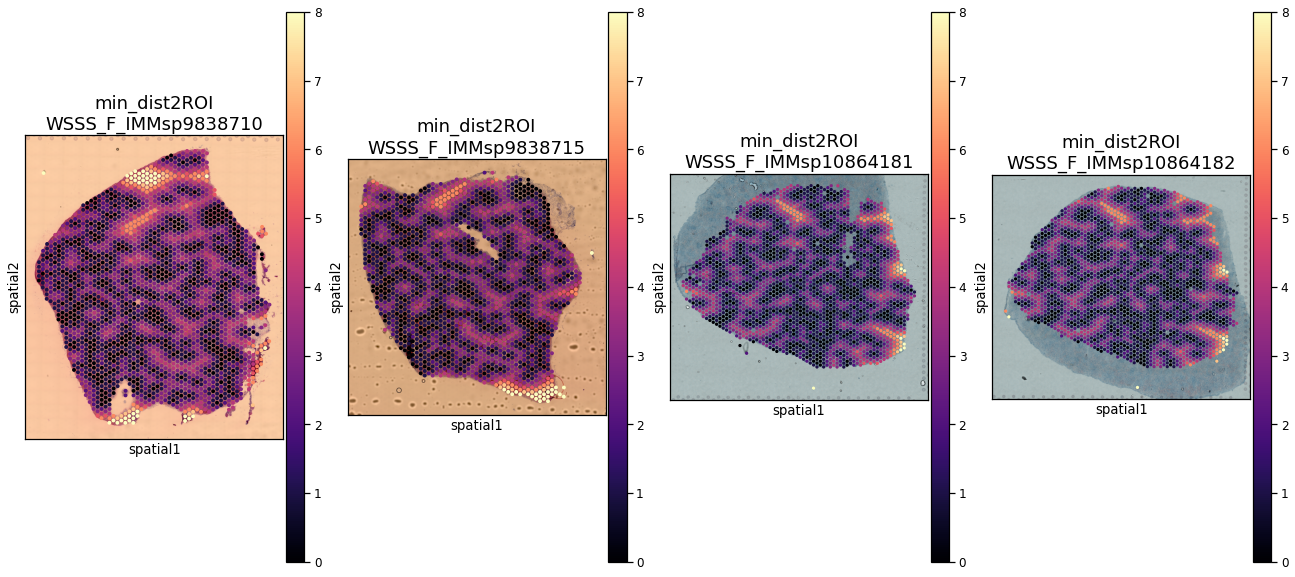

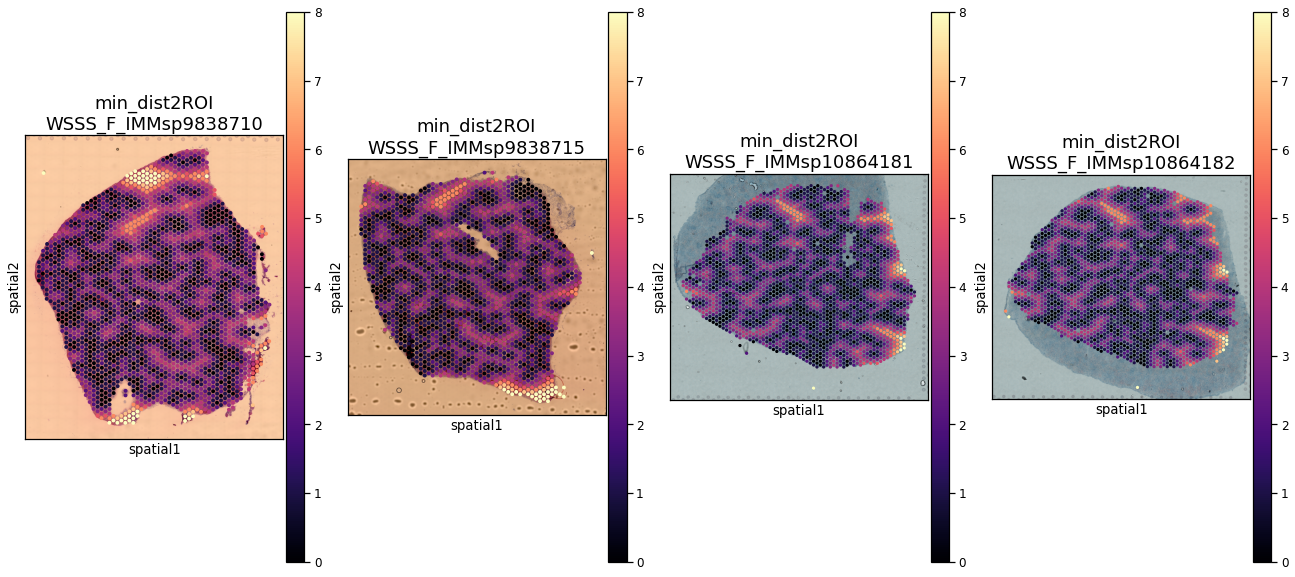

In [332]:
plot_spatial_per_cell_type(c2l_results["SP"], cell_type="min_dist2ROI", 
                           samples=vis_sample_metadata.index[vis_sample_metadata.Organ=="SP"], ncol=len(samples))

In [333]:
df = c2l_results["SP"].obs[['min_dist2ROI', "B_progenitors", "B_prog_region"]]
df.loc[df['B_progenitors'] > df.B_progenitors.quantile(0.992), 'B_progenitors'] = df.B_progenitors.quantile(0.992)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [340]:
%%R -i df
quants <- quantile(df$B_progenitors, seq(0,1,by=0.25))

In [343]:
%%R
df <- mutate(df, min_dist2ROI=ifelse(min_dist2ROI >= 6, 6, min_dist2ROI))

## Permutation test
n_spots <- sum(df$B_prog_region)
n_perm = 5000
pvals <- c()
means <- c()
for (i in 1:n_perm) {
    null_ixs <- sample(1:nrow(df), n_spots)
    df[,paste0('perm_', i)] <- 0
    df[null_ixs,paste0('perm_', i)] <- 1
#     ks_stat <- ks.test(df$min_dist2ROI[null_ixs], df$min_dist2ROI[df$B_prog_region==1])
    mean_dist <- mean(df$min_dist2ROI[null_ixs])
    means <- c(means, mean_dist)
#     pval <-ks_stat$p.value
#     pvals <- c(pvals, pval)
    }
# ks_stat <- ks.test(null_dist, df$min_dist2ROI[df$B_prog_region==1])

In [344]:
%%R
mean_dist_true <- mean(df$min_dist2ROI[df$B_prog_region==1])
perm_pval <- sum( mean_dist_true > means )/length( means )
perm_pval

[1] 0.0104


`summarise()` has grouped output by 'B_prog_region'. You can override using the `.groups` argument.


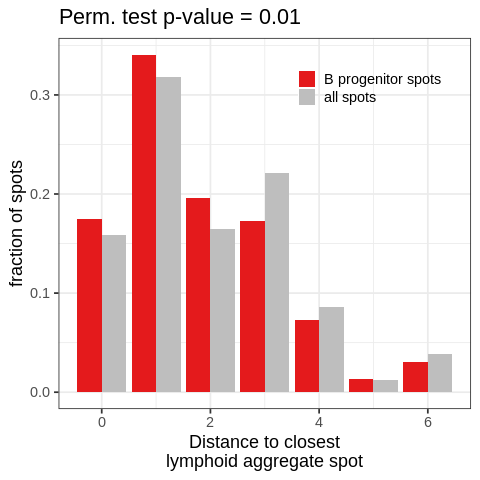

In [345]:
%%R -i figdir
df %>%
select(min_dist2ROI, B_prog_region) %>%
group_by(B_prog_region) %>%
mutate(n_all=n()) %>%
ungroup() %>%
group_by(B_prog_region, min_dist2ROI) %>%
summarise(n=n(), n_all=first(n_all)) %>%
ungroup() %>%
mutate(frac=n/n_all) %>%
mutate(B_prog_region=factor(as.character(B_prog_region), levels=c("1", '0'))) %>%
ggplot(aes(min_dist2ROI, frac, fill=B_prog_region)) +
geom_col(position='dodge') +
scale_fill_manual(name='', 
                  values=c(RColorBrewer::brewer.pal(2, "Set1")[1], 'grey'), 
                  labels=c("1"='B progenitor spots', "0"='all spots')) +
theme_bw(base_size=18) +
ylab('fraction of spots') +
xlab("Distance to closest\nlymphoid aggregate spot") +
theme(legend.position=c(0.95,0.9), legend.justification=c(hjust=1, vjust=0.5),
      legend.background=element_blank()
     ) +
ggtitle(paste0("Perm. test p-value = ", round(perm_pval, 3))) +
ggsave(paste0(figdir, 'distance_2_SP_lymph_aggregates.pdf'), height=7, width=8) 
# geom_histogram(position='identity', bins=10) +
# geom_density(data=. %>% filter(name=='B_prog_region'), color='red', position='identity', adjust = 3) 
# facet_grid(B_prog_region~.)

## Plot ligand-receptor analysis results

We identified ILC3, MACROPHAGE_LYVE1_HIGH and NK cells as cell types co-localising with B progenitors across liver/spleen/thymus. We filter interactions between B cell progenitors and these interactors in `src/07_widespread_hematopoiesis/B_progenitor_spatial_cpdb_paper_v4.R`. 


In [27]:
cpdb_df = pd.read_csv('csv/B_prog_cpdb_all.csv')

In [29]:
cpdb_df = cpdb_df.iloc[:,[0,1,4,7, 2, 5, 8, 3,6,9]]

In [30]:
cpdb_df

ligand_pair  LI-ILC3  SP-ILC3  TH-ILC3  LI-MACROPHAGE_LYVE1_HIGH  \
0   a4b1 complex_PLAUR   0.0000   0.0000   0.0000                    1.3028   
1    a4b1 complex_SPP1   0.0000   0.0000   0.0000                    2.2508   
2        ALOX5_ALOX5AP   0.6220   0.3216   1.0460                    0.4916   
3             APP_CD74   0.4108   0.0000   1.7104                    2.6604   
4            BAG6_NCR3   1.0186   0.9112   1.0150                    0.0000   
..                 ...      ...      ...      ...                       ...   
56        TNFRSF14_LTA   1.2610   1.2978   1.0228                    0.0000   
57    TNFRSF14_TNFSF14   0.7650   0.9998   0.6650                    0.0000   
58        TNFRSF1A_GRN   0.0000   0.0000   0.0000                    1.5382   
59        TNFRSF1A_TNF   0.1964   0.2008   0.0000                    0.7552   
60   Type II IFNR_IFNG   0.0000   0.0000   0.0000                    0.0000   

    SP-MACROPHAGE_LYVE1_HIGH  TH-MACROPHAGE_LYVE1_HIGH   LI-NK   SP-NK   TH-NK  
0                     0.9442                    1.5164  0.0000  0.0000  0.0000  
1                     1.6656                    1.6788  0.0000  0.0000  0.0000  
2                     0.2998                    1.0456  1.9968  1.7670  1.5524  
3                     3.0298                    3.2344  0.0000  0.0000  1.6434  
4                     0.0000                    0.0000  1.3210  1.2834  1.0262  
..                       ...                       ...     ...     ...     ...  
56                    0.0000                    0.0000  0.6466  0.0000  0.4676  
57                    0.0000                    0.0000  1.2302  1.2312  1.1166  
58                    1.3798                    1.7390  0.0000  0.0000  0.0000  
59                    0.0000                    1.0662  0.1960  0.0000  0.0000  
60                    0.0000                    0.0000  1.2714  1.3988  0.4664  

[61 rows x 10 columns]

In [31]:
cpdb_df.index = cpdb_df['ligand_pair']
cpdb_df = cpdb_df.drop(['ligand_pair'], 1)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list
clustering = ward(cpdb_df.values)
ordered_genes = cpdb_df.index[leaves_list(clustering)].tolist()
# X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

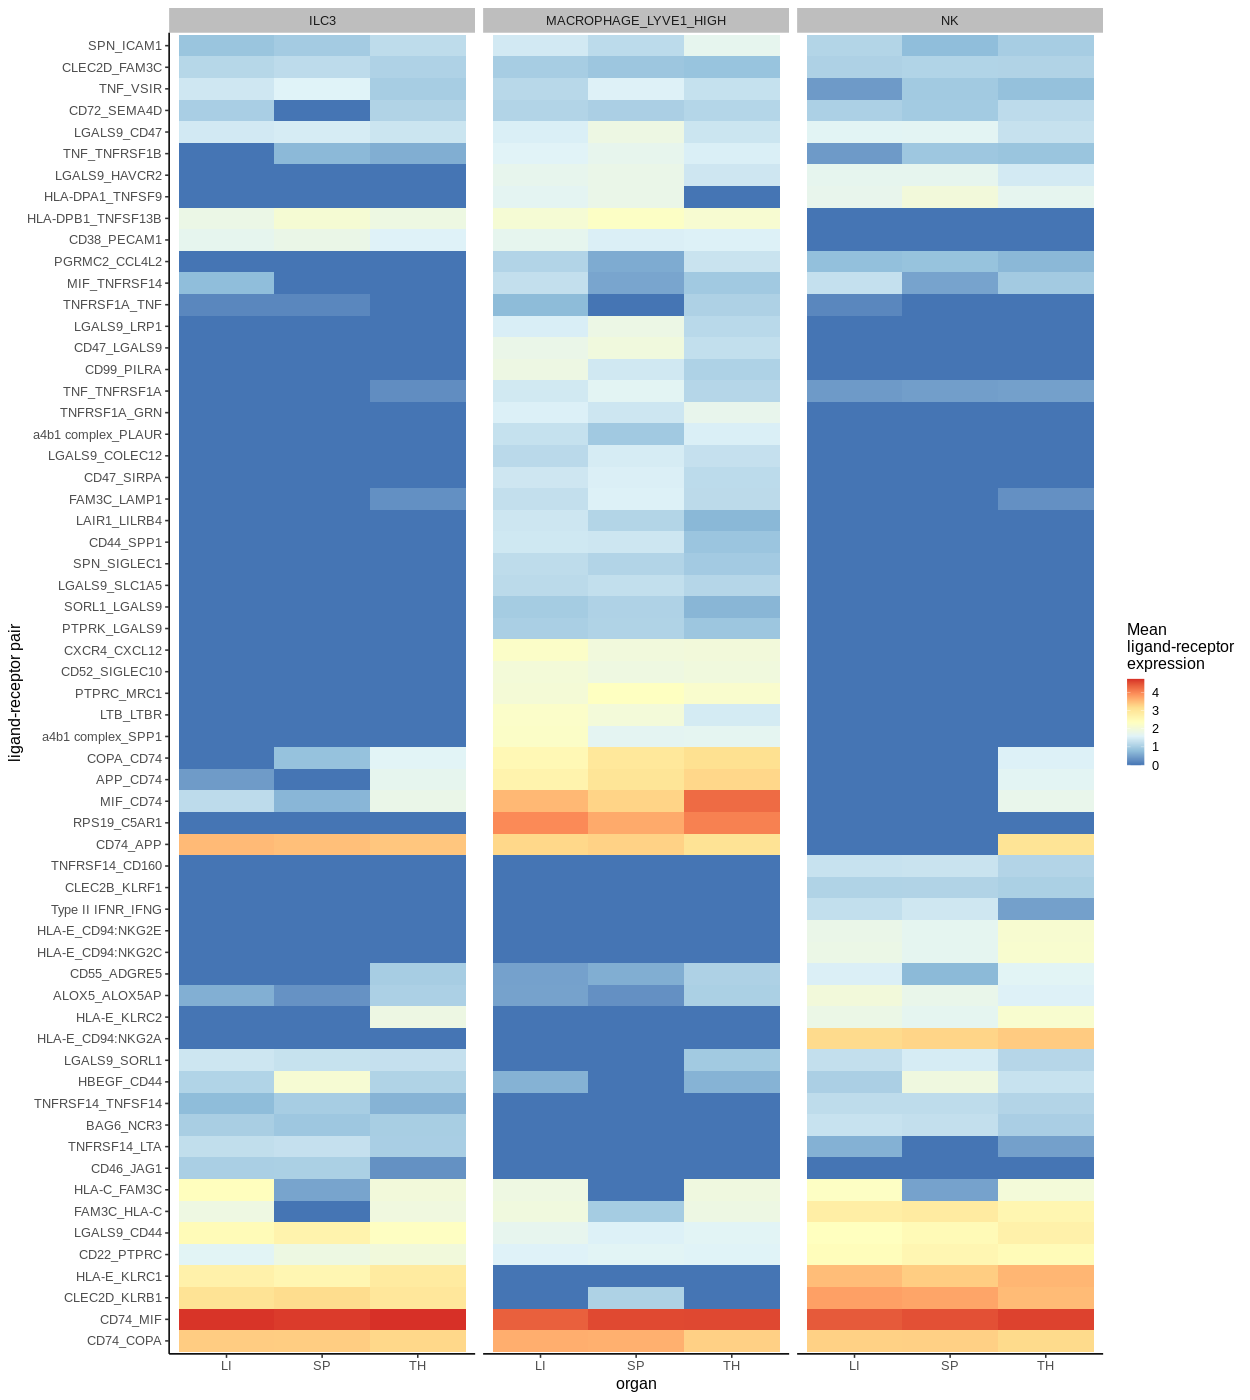

In [41]:
%%R -i cpdb_df -i ordered_genes -w 1250 -h 1400
library("dplyr") 
library('tidyr')
library('tidyverse')
library("ggplot2") 
cpdb_df %>%
    rownames_to_column('ligand_pair') %>%
    pivot_longer(cols=-c('ligand_pair'), names_to='celltype', values_to='mean_of_means') %>%
    separate('celltype', into=c("organ", 'celltype_pair'), sep='-') %>%
    mutate(ligand_pair=factor(ligand_pair, levels=ordered_genes)) %>%
    mutate(celltype_pair = str_replace(celltype_pair, '\\.', '\n')) %>%
    ggplot(aes(organ, ligand_pair, fill=mean_of_means)) +
    geom_tile() +
    facet_grid(.~celltype_pair) +
    scale_fill_distiller(palette="RdYlBu", name='Mean\nligand-receptor\nexpression') +
    ylab("ligand-receptor pair") +
    theme_classic(base_size=16) +
    theme(strip.background=element_rect(fill='grey', color=NA)) +
    ggsave('/home/jovyan/mount/gdrive/Pan_fetal/plots_output/chenqu_jhub/B_prog_cpdb_plot.pdf', width=12.5, height=14)